# Clusters de sapatos

## Introdução

Um dos maiores problemas do e-commerce é agrupar produtos baseado na visão do usuário e não em características como cor, preço e fabricante. Uma necessidade é corrigir preços.

Uma das formas de atacar este problema é usando as features conhecidas (preço, cores, fabricante, categorias da estrutura mercadológica, etc) par agerar um vetor que represente o produto, e encontrar clusters que os agrupem usando alguma métrica de distância vetorial.

Vamos atacar este problema com um dataset de sapatos.

## Dados

Temos um conjunto de dados de registros de vendas de sapatos, cada sapato está identificado por um *id* único, e as linhas o apresentam em diversas ofertas de lojas onlne com cores, a categorização do site em que é ofertado, condição da oferta (novo ou usado), marca e preço cobrado.

In [1]:
import pandas as pd
df = pd.read_json("shoes.json", orient="records", lines=True)

In [2]:
df.head(10)

,brand,categories,colors,condition,id,isSale,price
0,Naturalizer,"[Clothing, Heels, All Women's Shoes, Shoes, Sa...","[Silver, Cream]",USED,AVpfEf_hLJeJML431ueH,False,55.990
1,MUK LUKS,"[Clothing, All Women's Shoes, Women's Casual S...",[Grey],NEW,AVpi74XfLJeJML43qZAc,True,41.125
2,MUK LUKS,"[Clothing, All Women's Shoes, Women's Casual S...",[Grey],NEW,AVpi74XfLJeJML43qZAc,False,35.250
3,MUK LUKS,"[Clothing, All Women's Shoes, Shoes, Women's S...",[Black],NEW,AVpjXyCc1cnluZ0-V-Gj,False,24.750
4,MUK LUKS,"[Clothing, All Women's Shoes, Shoes, Women's S...",[Grey],NEW,AVphGKLPilAPnD_x1Nrm,True,31.695
5,Soft Ones,"[Clothing, All Womens Shoes, All Women's Shoes...",[Brown],NEW,AVpg91ziilAPnD_xziOo,True,10.950
6,MUK LUKS,"[Clothing, Women's Casual Shoes, All Women's S...","[Navy, Burgundy, Brown, Purple, Black, Natural...",USED,AVpjGKXyLJeJML43r8BH,False,18.395
7,MUK LUKS,"[Clothing, Women's Casual Shoes, All Women's S...","[Navy, Burgundy, Brown, Purple, Black, Natural...",USED,AVpjGKXyLJeJML43r8BH,False,18.395
8,MUK LUKS,"[Clothing, Shoes, Women's Shoes, All Women's S...","[Grey, Navy]",NEW,AVpfLXyhilAPnD_xWmNc,True,49.440
9,MUK LUKS,"[Clothing, All Women's Shoes, Shoes, Women's B...",[Brown],NEW,AVpfeWdJ1cnluZ0-lXYU,True,53.495


As colunas seguintes estão presentes:

* id: Código identificador de cada sapato
* brand: Marca do sapato
* categories: Categorias em que o sapato foi alocado no e-commerce onde a oferta é apresentada
* colors: Cores disponíveis
* condition: Se está usado ou novo.
* price: Preço cobrado pelo e-commerce em que está sendo ofertado.

## Desafio

1. Você deve usar o algoritmo de sua preferência para agrupar os sapatos de acordo com *condition*, *categories* e *colors* disponíveis gerando 4 clusters.

2. Para cada cluster encontrado, você deve calcular o preço médio e o desvio padrão de preço.

3. Como bônus, você pode apresentar os clusters num gráfico, mas essa etapa não é obrigatória.

Para tanto, tenha em mente as seguintes observações:

1. Um produto pode ser ofertado em mais de uma loja, portanto, pode aparecer mais de uma vez no conjunto de dados e ter valores para *categories*, *colors* e *condition* diferentes, você precisa reunir estes dados e criar um único registro para cada id.

2. Campos como *brand*, *categories*, *colors* e *condition* são **categóricos**, dependêndo do algoritmo utilizado você vai precisar aplicar alguma técnica como [codificação one-hot](https://medium.com/@arthurlambletvaz/one-hot-encoding-o-que-%C3%A9-cd2e8d302ae0) quando (e se) for utilizá-los.

## Passo 1 : Exploração dos Dados

Primeiro será feito uma exploração geral do dataset, verificando o seu tamanho, os tipos das colunas e se existem dados faltantes. Em seguida de cada coluna.  

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
brand         10000 non-null object
categories    10000 non-null object
colors        10000 non-null object
condition     10000 non-null object
id            10000 non-null object
isSale        10000 non-null bool
price         10000 non-null float64
dtypes: bool(1), float64(1), object(5)
memory usage: 478.6+ KB


* Tamanho do Dataset (10000,7)
* Nenhum Elemento NaN presente.

#### Expplorando a coluna id

In [4]:
#### Verificando a quantidade de ids unicos
df.id.nunique()

653

Existem 653 ids unicos sendo que na tabela existem 10000 elementos. Logo é necessário verificar os ids que se repetem e fazer um pre processamento nos dados para se ter um id por registro. 

#### Explorando a coluna brand (Marca do Sapato)

In [5]:
##Verificando a quantidade de marcas diferentes presentes
df['brand'] = df.brand.apply(lambda x: x.upper())
df['brand'].nunique()

116

Exitem 116 marcas difererentes. Vamos verificar quais as 10 marcas mais recorrentes

In [6]:
##Visualizando a quantidade de sapatos de cada marca no Dataframe
df.brand.value_counts().head(10)

JOURNEE COLLECTION                2182
LIFESTRIDE                        1593
A2 BY AEROSOLES                    670
EASY STREET                        585
STYLE CHARLES BY CHARLES DAVID     478
NIKE                               464
SO                                 422
DR. SCHOLLS                        337
SKECHERS                           336
CROFT BARROW                       315
Name: brand, dtype: int64

#### Explorando Categories

Para ajudar a analisar a coluna Categories onde cada registro é uma lista, a classe MultiLabelBinarizer da biblioteca Sklearn será utilizada. Nesta exploração será uma lista de todas as diferentes categorias,será vista quais as categrias mais frequentes. 

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer
pd.set_option('display.max_columns',250)

In [8]:
mlb = MultiLabelBinarizer()
mlb.fit(df.categories)
categories_list = list(mlb.classes_)
categories_list

['2 Lips Too',
 'A2 by Aerosoles',
 'ASICS',
 "All Men's Shoes",
 "All Women's Shoes",
 'All Womens Shoes',
 'Andrew Geller',
 'Apt. 9',
 'Athletic',
 'Athletic Shoes',
 'Baby & Kids Shoes',
 'Baby & Toddler Shoes',
 'Barrow',
 'Betula by Birkenstock',
 'Boat Shoes',
 'Boots',
 "Boys' Shoes",
 "Candie's",
 'Clarks',
 'Clogs',
 'Clothing',
 'Comfort',
 'Corkys',
 'Cowboy Boots',
 'Croft',
 'Dolce by Mojo Moxy',
 "Dr. Scholl's",
 'Eastland',
 'Easy Street',
 'FILA',
 'Fergalicious',
 'Fitness',
 'Flats',
 'Forever Collectibles',
 "Girls' Boots",
 "Girls' Shoes",
 'Heels',
 'Henry Ferrera',
 'Herstar',
 'Home Improvement',
 'Jennifer Lopez',
 'Journee Collection',
 'K-Swiss',
 'Keds',
 'Kisses by 2 Lips Too',
 'Koolaburra by UGG',
 'LC Lauren Conrad',
 'Laredo',
 'LifeStride',
 'Loafers',
 'Low Slide Sandals',
 'Lugz',
 'MUK LUKS',
 "Men's Athletic Shoes",
 "Men's Casual Shoes",
 "Men's Shoes",
 'Mid-Calf Boots',
 'Mules',
 'NYLA',
 'NaturalSoul by naturalizer',
 'New Balance',
 'Nike',
 

In [9]:
len(categories_list)

124

In [10]:
array =  mlb.fit_transform(df.categories)
categories_count= array.sum(axis=0)
categories_counts = pd.DataFrame(categories_count.reshape(1,-1), columns =mlb.classes_ ,index= ['count'])
categories_counts.sort_values('count',axis=1,ascending= False)

,Shoes,Womens,Women's Shoes,Clothing,Boots,Journee Collection,Heels,Pumps,All Women's Shoes,Sandals,LifeStride,Sneakers,Athletic Shoes,Flats,A2 by Aerosoles,Women's Casual Shoes,Easy Street,Style Charles by Charles David,Mules,Clogs,Nike,Women's Dress Shoes,Women's Footwear,Women's Athletic Shoes,Dr. Scholl's,Skechers,Loafers,Barrow,Croft,New Balance,SONOMA Goods for Life,Women's Running Shoes,Apt. 9,Womens Shoes,Simply Vera Vera Wang,Women's Casual Boots & Shoes,Ryka,Candie's,Womens Casual Shoes,Women's Boots,ASICS,NaturalSoul by naturalizer,Women's Road Running Shoes,Women's Trail Running Shoes,madden NYC,Comfort,All Womens Shoes,Spring Step,adidas,LC Lauren Conrad,Men's Shoes,Dolce by Mojo Moxy,Eastland,Unionbay,Shoes & Accessories,Clarks,Men's Athletic Shoes,Soft Style by Hush Puppies,Jennifer Lopez,Vans,FILA,Kisses by 2 Lips Too,Keds,Athletic,Rampage,Men's Casual Shoes,Other Slip-Ons,2 Lips Too,Low Slide Sandals,Koolaburra by UGG,Sandals & Flip Flops,Womens Sport Sandals,Womens Sandals & Flip Flops,Seven7,Women,Boat Shoes,Sporting Goods,Under Armour,Fitness,Running & Yoga,Rocky 4EurSole,Slip-ons,K-Swiss,Slippers,Women's Clothing,sugar,PUMA,Women's Slippers,REEF,Shop by Clothing Type,All Men's Shoes,Women's Winter Boots,Cowboy Boots,Laredo,Women's Red Wing Shoes,Oxfords,Lugz,Boys' Shoes,Fergalicious,Qupid,Andrew Geller,Work Safety Clothing and Equipment,Home Improvement,MUK LUKS,Women's New Balance Shoes,Womens Comfort,Womens Comfort Boots & Booties,Henry Ferrera,Herstar,Women's Wear to Work,Baby & Kids Shoes,Girls' Shoes,Womens Oxfords,Baby & Toddler Shoes,Betula by Birkenstock,Corkys,Womens Oxford & Loafers,NYLA,Women's Work & Safety Shoes,Mid-Calf Boots,Women's Sandals,Forever Collectibles,Girls' Boots,Olivia Miller
count,9631,9558,2466,2436,2238,2221,2042,2027,1897,1814,1593,1578,1578,1247,670,645,585,478,476,476,448,368,352,344,337,336,320,315,315,255,229,201,183,166,164,151,147,144,127,123,111,107,101,100,84,82,80,79,74,69,61,58,56,55,40,39,35,25,24,24,23,23,22,22,20,20,20,19,19,18,18,17,17,14,13,12,11,11,11,11,11,10,10,9,8,8,7,7,7,6,6,6,6,6,5,5,5,4,4,3,3,3,3,3,3,3,3,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1


Nota: Existem 124 categorias diferentes, sendo que as três mais categories mais frequentes são **Shoes**, **Womens** e **Women's Shoes**; categorias essas que não são muito uteis distinguir um sapato dos demais.

#### Explorando Colors

A exploração desta coluna segurá os mesmos procedimentos da coluna **categories**

In [11]:
colors = MultiLabelBinarizer()
colors.fit(df.colors)
colors_list = list(colors.classes_)
colors_list

['Angora',
 'Anthracitedark',
 'Antique',
 'AquariumFlashCoralBlueJewel',
 'Aquifer',
 'Armory',
 'Aruba',
 'Asphalt',
 'Atomic',
 'Azalea',
 'Basalt',
 'Bayou',
 'Beaujolaiswhite',
 'Beige',
 'Birch',
 'Bird',
 'Black',
 'Black-Purple-Print',
 'Blackblack',
 'Blackchrome-Aurora',
 'Blackcotton',
 'Blackfrost',
 'Blackgreen',
 'Blackgreenbrown',
 'Blackgrey',
 'Blackmetallic',
 'Blacksilver',
 'Blacksmoky',
 'Blackwatch',
 'Blackwhite',
 'Bleach',
 'Blue',
 'Blueblue',
 'Blueprint',
 'Bomber',
 'Bone',
 'Bordo',
 'Brindle',
 'Bronze',
 'Brooke',
 'Brown',
 'Brownbark',
 'Brunette',
 'Buckskin',
 'Burgundy',
 'Cabana',
 'Calypso',
 'Capri',
 'Caraibes',
 'Carbon',
 'Cashew',
 'Castlerock',
 'Ceramic',
 'Charcoal',
 'Charcoalcreamgumblue-Black',
 'Cherries',
 'Chestnut',
 'Chocolate',
 'Clematis',
 'Coffee',
 'Cognac',
 'Cool',
 'Coral',
 'Coraltaupe',
 'Core',
 'Coreblack',
 'Cream',
 'Dark',
 'Deep',
 'Diva',
 'Easy',
 'Ebony-Silver-Pink',
 'Eggplant',
 'Emerald',
 'Evening',
 'Fabric'

In [12]:
len(colors_list)

223

In [13]:
array = colors.fit_transform(df.colors)
colors_counts = array.sum(axis=0)
colors_count = pd.DataFrame(colors_counts.reshape(1,-1), columns =colors.classes_ ,index= ['count'])
colors_count.sort_values('count',axis=1,ascending=False)

,NA,Black,White,Navy,Grey,Blue,Pewter,Taupe,Brown,Silver,Stone,Red,Dark,Gray,Tan,Luxe,Pure,Blackchrome-Aurora,Beige,Soft,Gold,Natural,Punch,Luggage,Bone,Inkdeadly,Anthracitedark,Blackmetallic,Bronze,Turquo,Yellow,Coral,Ivory,Blackwhite,Pink,Metallic,Pewterchampagne,Light,Tornado,Mushroom,Gore,Nude,Pinot,Purpleblack,Lux,Me,Blackblack,Blacksilver,Multi-Color,Purple,Teal,Blackgrey,Insignia,Chocolate,Leopard,Rainbow,Redpink,Tanwhite,Frost,Redyellow,Coraltaupe,Greypurple,Blackgreenbrown,Blackgreen,Blueblue,Blackfrost,Calypso,Blackcotton,Whitegrey,Medium,Chestnut,Whitefire,Charcoal,Bordo,Peach,Poseidon,Wine,Tibetan,Quarry,Deep,Bird,Hawaiian,Slateblue,Koa,Aruba,Core,Basalt,Easy,Vintage,Fabric,AquariumFlashCoralBlueJewel,Turquoise,Burgundy,Marlin,Pigeon,Jiffy,Marine,Mica,Rose,Slate,Honey,Footwear,Birch,Pearl,Cream,Morning,Mojolica,Raspberry,Greyblack,Coreblack,Navyblue,Cognac,Eggplant,Beaujolaiswhite,Diva,Bomber,Bleach,Blacksmoky,Noble,Raw,Whitebrooke,Utility,Highrisewhite,Brooke,Whitewhite,Fair,Virtual,Flamingo,Stingraywhite,Nobile,Sage,Gunsmoke,Antique,Golden,Charcoalcreamgumblue-Black,Blackwatch,Ceramic,Mahogany,Ice,Raspberrywhite,Evening,Black-Purple-Print,Purple-Pink-Teal,Primer,Glacier,Brownbark,Bayou,Super,Brunette,Navy-Teal-Mint,Navy-Plum-Ice,Ebony-Silver-Pink,Fatigue,Fiji,Fjord,Clematis,Twilight,Wheat,Cashew,Caraibes,Licorice,Madder,Reflecting,Wood,Mocha,Tibet,Azalea,Sangria,Aquifer,Cool,Premier,Brindle,Emerald,Fuchsia,Habana,Indigo,True,Tobacco,Medieval,Moccasin,Blueprint,Mustang,Neutral,Summit,Turbulence,Steel,Team,Sweet,Tideline,Angora,Sand,Khaki,Armory,Asphalt,Atomic,Buckskin,Cabana,Capri,Carbon,Castlerock,Cherries,Coffee,Floral,Fusion,Graysilver,Hot,Kiwi,Regatta,Lilac,Maroon,Mauve,Mint,N,Nasturtium,Naturalgold,Neon,Olive,Orange,Orchid,Oro,Oyster,Platinum,Liberty
count,7369,1562,559,523,418,412,343,328,314,300,295,291,273,272,213,191,185,185,165,163,121,99,86,77,74,72,72,64,58,48,48,48,46,46,44,43,43,41,39,39,39,37,34,34,34,34,29,29,29,28,27,24,22,21,19,19,18,18,18,18,18,18,18,18,18,18,18,18,18,17,17,17,15,14,14,14,13,13,13,13,13,13,13,12,12,12,12,12,12,11,11,10,10,8,8,8,8,7,7,7,7,7,7,7,6,6,6,6,6,6,6,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,4,4,4,4,4,4,4,4,4,4,4,4,4,4,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


Nota: A maior parte dos sapatos estão com o campo cor vazio, representado pela classe 'NA' com 7369 ocorrências.Além dessa classe existem 222 classes de cores diferentes. 

#### Explorando Condition

Verificação da quantidade de ocorrências de cada classe.

In [14]:
df.condition.value_counts()

USED    9562
NEW      438
Name: condition, dtype: int64

#### Explorando IsSale

Verificação da quantidade de ocorrências de cada classe.

In [15]:
df.isSale.value_counts()

False    9830
True      170
Name: isSale, dtype: int64

#### Explorando Price

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

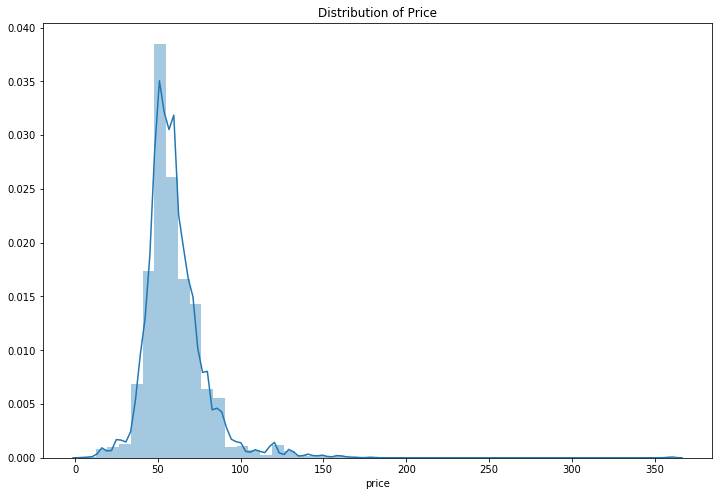

In [17]:
%matplotlib inline
plt.figure(figsize=(12,8))
plt.title('Distribution of Price')
sns.distplot(df['price'], hist=True,kde=True)

## Passo 2: Pre-Processamento dos Dados

Na etapa do pre-processamento dos dados serão feitos os seguntes procedimentos:

   * Aplicar codificação one hot-encoding nas colunas **categories** e **colors**.
   * Aplicar codificação label encoding na coluna **condition**
   * Reunir os produtos com mesmo **Id** de mode que cada **Id** oucupe apenas um registro no Dataframe.

### Passo 2.1: Aplicação da codificação one hot encoding nas colunas categories e colors.

Para auxiliar na codificação one hot-encoding será utilizada a classe MultiLabelBinarizer da biblioteca sklearn. 

In [18]:
### One hot encoding para categories
mlb = MultiLabelBinarizer()
mlb.fit(df['categories'])
categories_onehot = mlb.fit_transform(df['categories'])
df_categories = pd.DataFrame(categories_onehot,columns= mlb.classes_)

In [19]:
df_categories.head()

,2 Lips Too,A2 by Aerosoles,ASICS,All Men's Shoes,All Women's Shoes,All Womens Shoes,Andrew Geller,Apt. 9,Athletic,Athletic Shoes,Baby & Kids Shoes,Baby & Toddler Shoes,Barrow,Betula by Birkenstock,Boat Shoes,Boots,Boys' Shoes,Candie's,Clarks,Clogs,Clothing,Comfort,Corkys,Cowboy Boots,Croft,Dolce by Mojo Moxy,Dr. Scholl's,Eastland,Easy Street,FILA,Fergalicious,Fitness,Flats,Forever Collectibles,Girls' Boots,Girls' Shoes,Heels,Henry Ferrera,Herstar,Home Improvement,Jennifer Lopez,Journee Collection,K-Swiss,Keds,Kisses by 2 Lips Too,Koolaburra by UGG,LC Lauren Conrad,Laredo,LifeStride,Loafers,Low Slide Sandals,Lugz,MUK LUKS,Men's Athletic Shoes,Men's Casual Shoes,Men's Shoes,Mid-Calf Boots,Mules,NYLA,NaturalSoul by naturalizer,New Balance,Nike,Olivia Miller,Other Slip-Ons,Oxfords,PUMA,Pumps,Qupid,REEF,Rampage,Rocky 4EurSole,Running & Yoga,Ryka,SONOMA Goods for Life,Sandals,Sandals & Flip Flops,Seven7,Shoes,Shoes & Accessories,Shop by Clothing Type,Simply Vera Vera Wang,Skechers,Slip-ons,Slippers,Sneakers,Soft Style by Hush Puppies,Sporting Goods,Spring Step,Style Charles by Charles David,Under Armour,Unionbay,Vans,Women,Women's Athletic Shoes,Women's Boots,Women's Casual Boots & Shoes,Women's Casual Shoes,Women's Clothing,Women's Dress Shoes,Women's Footwear,Women's New Balance Shoes,Women's Red Wing Shoes,Women's Road Running Shoes,Women's Running Shoes,Women's Sandals,Women's Shoes,Women's Slippers,Women's Trail Running Shoes,Women's Wear to Work,Women's Winter Boots,Women's Work & Safety Shoes,Womens,Womens Casual Shoes,Womens Comfort,Womens Comfort Boots & Booties,Womens Oxford & Loafers,Womens Oxfords,Womens Sandals & Flip Flops,Womens Shoes,Womens Sport Sandals,Work Safety Clothing and Equipment,adidas,madden NYC,sugar
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
## Join Datasets
df = pd.merge(df,df_categories,how='inner',left_index=True,right_index=True)

In [21]:
### One hot encoding para colors
mlb2 = MultiLabelBinarizer()
mlb2.fit(df['colors'])
colors_onehot = mlb2.fit_transform(df['colors'])
df_colors = pd.DataFrame(colors_onehot,columns= mlb2.classes_)

In [22]:
## Join Datasets
df = pd.merge(df,df_colors,how='inner',left_index=True,right_index=True)
df.head()

,brand,categories,colors,condition,id,isSale,price,2 Lips Too,A2 by Aerosoles,ASICS,All Men's Shoes,All Women's Shoes,All Womens Shoes,Andrew Geller,Apt. 9,Athletic,Athletic Shoes,Baby & Kids Shoes,Baby & Toddler Shoes,Barrow,Betula by Birkenstock,Boat Shoes,Boots,Boys' Shoes,Candie's,Clarks,Clogs,Clothing,Comfort,Corkys,Cowboy Boots,Croft,Dolce by Mojo Moxy,Dr. Scholl's,Eastland,Easy Street,FILA,Fergalicious,Fitness,Flats,Forever Collectibles,Girls' Boots,Girls' Shoes,Heels,Henry Ferrera,Herstar,Home Improvement,Jennifer Lopez,Journee Collection,K-Swiss,Keds,Kisses by 2 Lips Too,Koolaburra by UGG,LC Lauren Conrad,Laredo,LifeStride,Loafers,Low Slide Sandals,Lugz,MUK LUKS,Men's Athletic Shoes,Men's Casual Shoes,Men's Shoes,Mid-Calf Boots,Mules,NYLA,NaturalSoul by naturalizer,New Balance,Nike,Olivia Miller,Other Slip-Ons,Oxfords,PUMA,Pumps,Qupid,REEF,Rampage,Rocky 4EurSole,Running & Yoga,Ryka,SONOMA Goods for Life,Sandals,Sandals & Flip Flops,Seven7,Shoes,Shoes & Accessories,Shop by Clothing Type,Simply Vera Vera Wang,Skechers,Slip-ons,Slippers,Sneakers,Soft Style by Hush Puppies,Sporting Goods,Spring Step,Style Charles by Charles David,Under Armour,Unionbay,Vans,Women,Women's Athletic Shoes,Women's Boots,Women's Casual Boots & Shoes,Women's Casual Shoes,Women's Clothing,Women's Dress Shoes,Women's Footwear,Women's New Balance Shoes,Women's Red Wing Shoes,Women's Road Running Shoes,Women's Running Shoes,Women's Sandals,Women's Shoes,Women's Slippers,Women's Trail Running Shoes,Women's Wear to Work,Women's Winter Boots,Women's Work & Safety Shoes,Womens,Womens Casual Shoes,Womens Comfort,Womens Comfort Boots & Booties,Womens Oxford & Loafers,Womens Oxfords,Womens Sandals & Flip Flops,...,Highrisewhite,Honey,Hot,Ice,Indigo,Inkdeadly,Insignia,Ivory,Jiffy,Khaki,Kiwi,Koa,Leopard,Liberty,Licorice,Light,Lilac,Luggage,Lux,Luxe,Madder,Mahogany,Marine,Marlin,Maroon,Mauve,Me,Medieval,Medium,Metallic,Mica,Mint,Moccasin,Mocha,Mojolica,Morning,Multi-Color,Mushroom,Mustang,N,NA,Nasturtium,Natural,Naturalgold,Navy,Navy-Plum-Ice,Navy-Teal-Mint,Navyblue,Neon,Neutral,Nobile,Noble,Nude,Olive,Orange,Orchid,Oro,Oyster,Peach,Pearl,Pewter,Pewterchampagne,Pigeon,Pink,Pinot,Platinum,Poseidon,Premier,Primer,Punch,Pure,Purple,Purple-Pink-Teal,Purpleblack,Quarry,Rainbow,Raspberry,Raspberrywhite,Raw,Red,Redpink,Redyellow,Reflecting,Regatta,Rose,Sage,Sand,Sangria,Silver,Slate,Slateblue,Soft,Steel,Stingraywhite,Stone,Summit,Super,Sweet,Tan,Tanwhite,Taupe,Teal,Team,Tibet,Tibetan,Tideline,Tobacco,Tornado,True,Turbulence,Turquo,Turquoise,Twilight,Utility,Vintage,Virtual,Wheat,White,Whitebrooke,Whitefire,Whitegrey,Whitewhite,Wine,Wood,Yellow
0,NATURALIZER,"[Clothing, Heels, All Women's Shoes, Shoes, Sa...","[Silver, Cream]",USED,AVpfEf_hLJeJML431ueH,False,55.990,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,MUK LUKS,"[Clothing, All Women's Shoes, Women's Casual S...",[Grey],NEW,AVpi74XfLJeJML43qZAc,True,41.125,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,MUK LUKS,"[Clothing, All Women's Shoes, Women's Casual S...",[Grey],NEW,AVpi74XfLJeJML43qZAc,False,35.250,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,

In [23]:
## Remoção das colunas categories e condition
df.drop(['categories','colors'],axis=1,inplace=True)
df.head()

,brand,condition,id,isSale,price,2 Lips Too,A2 by Aerosoles,ASICS,All Men's Shoes,All Women's Shoes,All Womens Shoes,Andrew Geller,Apt. 9,Athletic,Athletic Shoes,Baby & Kids Shoes,Baby & Toddler Shoes,Barrow,Betula by Birkenstock,Boat Shoes,Boots,Boys' Shoes,Candie's,Clarks,Clogs,Clothing,Comfort,Corkys,Cowboy Boots,Croft,Dolce by Mojo Moxy,Dr. Scholl's,Eastland,Easy Street,FILA,Fergalicious,Fitness,Flats,Forever Collectibles,Girls' Boots,Girls' Shoes,Heels,Henry Ferrera,Herstar,Home Improvement,Jennifer Lopez,Journee Collection,K-Swiss,Keds,Kisses by 2 Lips Too,Koolaburra by UGG,LC Lauren Conrad,Laredo,LifeStride,Loafers,Low Slide Sandals,Lugz,MUK LUKS,Men's Athletic Shoes,Men's Casual Shoes,Men's Shoes,Mid-Calf Boots,Mules,NYLA,NaturalSoul by naturalizer,New Balance,Nike,Olivia Miller,Other Slip-Ons,Oxfords,PUMA,Pumps,Qupid,REEF,Rampage,Rocky 4EurSole,Running & Yoga,Ryka,SONOMA Goods for Life,Sandals,Sandals & Flip Flops,Seven7,Shoes,Shoes & Accessories,Shop by Clothing Type,Simply Vera Vera Wang,Skechers,Slip-ons,Slippers,Sneakers,Soft Style by Hush Puppies,Sporting Goods,Spring Step,Style Charles by Charles David,Under Armour,Unionbay,Vans,Women,Women's Athletic Shoes,Women's Boots,Women's Casual Boots & Shoes,Women's Casual Shoes,Women's Clothing,Women's Dress Shoes,Women's Footwear,Women's New Balance Shoes,Women's Red Wing Shoes,Women's Road Running Shoes,Women's Running Shoes,Women's Sandals,Women's Shoes,Women's Slippers,Women's Trail Running Shoes,Women's Wear to Work,Women's Winter Boots,Women's Work & Safety Shoes,Womens,Womens Casual Shoes,Womens Comfort,Womens Comfort Boots & Booties,Womens Oxford & Loafers,Womens Oxfords,Womens Sandals & Flip Flops,Womens Shoes,Womens Sport Sandals,...,Highrisewhite,Honey,Hot,Ice,Indigo,Inkdeadly,Insignia,Ivory,Jiffy,Khaki,Kiwi,Koa,Leopard,Liberty,Licorice,Light,Lilac,Luggage,Lux,Luxe,Madder,Mahogany,Marine,Marlin,Maroon,Mauve,Me,Medieval,Medium,Metallic,Mica,Mint,Moccasin,Mocha,Mojolica,Morning,Multi-Color,Mushroom,Mustang,N,NA,Nasturtium,Natural,Naturalgold,Navy,Navy-Plum-Ice,Navy-Teal-Mint,Navyblue,Neon,Neutral,Nobile,Noble,Nude,Olive,Orange,Orchid,Oro,Oyster,Peach,Pearl,Pewter,Pewterchampagne,Pigeon,Pink,Pinot,Platinum,Poseidon,Premier,Primer,Punch,Pure,Purple,Purple-Pink-Teal,Purpleblack,Quarry,Rainbow,Raspberry,Raspberrywhite,Raw,Red,Redpink,Redyellow,Reflecting,Regatta,Rose,Sage,Sand,Sangria,Silver,Slate,Slateblue,Soft,Steel,Stingraywhite,Stone,Summit,Super,Sweet,Tan,Tanwhite,Taupe,Teal,Team,Tibet,Tibetan,Tideline,Tobacco,Tornado,True,Turbulence,Turquo,Turquoise,Twilight,Utility,Vintage,Virtual,Wheat,White,Whitebrooke,Whitefire,Whitegrey,Whitewhite,Wine,Wood,Yellow
0,NATURALIZER,USED,AVpfEf_hLJeJML431ueH,False,55.990,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,MUK LUKS,NEW,AVpi74XfLJeJML43qZAc,True,41.125,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,MUK LUKS,NEW,AVpi74XfLJeJML43qZAc,False,35.250,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,

### Passo 2.2: Aplicação codificação label encoding na coluna **condition**.

In [24]:
df.condition.replace(to_replace = ['USED','NEW'], value=[0,1],inplace=True)
df.head()

,brand,condition,id,isSale,price,2 Lips Too,A2 by Aerosoles,ASICS,All Men's Shoes,All Women's Shoes,All Womens Shoes,Andrew Geller,Apt. 9,Athletic,Athletic Shoes,Baby & Kids Shoes,Baby & Toddler Shoes,Barrow,Betula by Birkenstock,Boat Shoes,Boots,Boys' Shoes,Candie's,Clarks,Clogs,Clothing,Comfort,Corkys,Cowboy Boots,Croft,Dolce by Mojo Moxy,Dr. Scholl's,Eastland,Easy Street,FILA,Fergalicious,Fitness,Flats,Forever Collectibles,Girls' Boots,Girls' Shoes,Heels,Henry Ferrera,Herstar,Home Improvement,Jennifer Lopez,Journee Collection,K-Swiss,Keds,Kisses by 2 Lips Too,Koolaburra by UGG,LC Lauren Conrad,Laredo,LifeStride,Loafers,Low Slide Sandals,Lugz,MUK LUKS,Men's Athletic Shoes,Men's Casual Shoes,Men's Shoes,Mid-Calf Boots,Mules,NYLA,NaturalSoul by naturalizer,New Balance,Nike,Olivia Miller,Other Slip-Ons,Oxfords,PUMA,Pumps,Qupid,REEF,Rampage,Rocky 4EurSole,Running & Yoga,Ryka,SONOMA Goods for Life,Sandals,Sandals & Flip Flops,Seven7,Shoes,Shoes & Accessories,Shop by Clothing Type,Simply Vera Vera Wang,Skechers,Slip-ons,Slippers,Sneakers,Soft Style by Hush Puppies,Sporting Goods,Spring Step,Style Charles by Charles David,Under Armour,Unionbay,Vans,Women,Women's Athletic Shoes,Women's Boots,Women's Casual Boots & Shoes,Women's Casual Shoes,Women's Clothing,Women's Dress Shoes,Women's Footwear,Women's New Balance Shoes,Women's Red Wing Shoes,Women's Road Running Shoes,Women's Running Shoes,Women's Sandals,Women's Shoes,Women's Slippers,Women's Trail Running Shoes,Women's Wear to Work,Women's Winter Boots,Women's Work & Safety Shoes,Womens,Womens Casual Shoes,Womens Comfort,Womens Comfort Boots & Booties,Womens Oxford & Loafers,Womens Oxfords,Womens Sandals & Flip Flops,Womens Shoes,Womens Sport Sandals,...,Highrisewhite,Honey,Hot,Ice,Indigo,Inkdeadly,Insignia,Ivory,Jiffy,Khaki,Kiwi,Koa,Leopard,Liberty,Licorice,Light,Lilac,Luggage,Lux,Luxe,Madder,Mahogany,Marine,Marlin,Maroon,Mauve,Me,Medieval,Medium,Metallic,Mica,Mint,Moccasin,Mocha,Mojolica,Morning,Multi-Color,Mushroom,Mustang,N,NA,Nasturtium,Natural,Naturalgold,Navy,Navy-Plum-Ice,Navy-Teal-Mint,Navyblue,Neon,Neutral,Nobile,Noble,Nude,Olive,Orange,Orchid,Oro,Oyster,Peach,Pearl,Pewter,Pewterchampagne,Pigeon,Pink,Pinot,Platinum,Poseidon,Premier,Primer,Punch,Pure,Purple,Purple-Pink-Teal,Purpleblack,Quarry,Rainbow,Raspberry,Raspberrywhite,Raw,Red,Redpink,Redyellow,Reflecting,Regatta,Rose,Sage,Sand,Sangria,Silver,Slate,Slateblue,Soft,Steel,Stingraywhite,Stone,Summit,Super,Sweet,Tan,Tanwhite,Taupe,Teal,Team,Tibet,Tibetan,Tideline,Tobacco,Tornado,True,Turbulence,Turquo,Turquoise,Twilight,Utility,Vintage,Virtual,Wheat,White,Whitebrooke,Whitefire,Whitegrey,Whitewhite,Wine,Wood,Yellow
0,NATURALIZER,0,AVpfEf_hLJeJML431ueH,False,55.990,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,MUK LUKS,1,AVpi74XfLJeJML43qZAc,True,41.125,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,MUK LUKS,1,AVpi74XfLJeJML43qZAc,False,35.250,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0

### Passo 2.3 : União dos Produtos com mesmo ID

Será criada uma nova Tabela **df_sapatos** one cada registro da tabela será referente a um único **Id**. Como o objetivo e criar 4 clusters de acordo com conditions, colors e categories dos produtos. Como o objetivo e criar 4 clusters de acordo com conditions, colors e categories dos produtos; as colunas **isSale** e **brand**  não estarão em **df_sapatos**. O campo **preço** será a média dos preços de um determinado id, o campo **std** será o desvio padrão desses preços.

In [25]:
new_columns = categories_list + colors_list
new_columns

['2 Lips Too',
 'A2 by Aerosoles',
 'ASICS',
 "All Men's Shoes",
 "All Women's Shoes",
 'All Womens Shoes',
 'Andrew Geller',
 'Apt. 9',
 'Athletic',
 'Athletic Shoes',
 'Baby & Kids Shoes',
 'Baby & Toddler Shoes',
 'Barrow',
 'Betula by Birkenstock',
 'Boat Shoes',
 'Boots',
 "Boys' Shoes",
 "Candie's",
 'Clarks',
 'Clogs',
 'Clothing',
 'Comfort',
 'Corkys',
 'Cowboy Boots',
 'Croft',
 'Dolce by Mojo Moxy',
 "Dr. Scholl's",
 'Eastland',
 'Easy Street',
 'FILA',
 'Fergalicious',
 'Fitness',
 'Flats',
 'Forever Collectibles',
 "Girls' Boots",
 "Girls' Shoes",
 'Heels',
 'Henry Ferrera',
 'Herstar',
 'Home Improvement',
 'Jennifer Lopez',
 'Journee Collection',
 'K-Swiss',
 'Keds',
 'Kisses by 2 Lips Too',
 'Koolaburra by UGG',
 'LC Lauren Conrad',
 'Laredo',
 'LifeStride',
 'Loafers',
 'Low Slide Sandals',
 'Lugz',
 'MUK LUKS',
 "Men's Athletic Shoes",
 "Men's Casual Shoes",
 "Men's Shoes",
 'Mid-Calf Boots',
 'Mules',
 'NYLA',
 'NaturalSoul by naturalizer',
 'New Balance',
 'Nike',
 

In [26]:
colunas_usadas = ['condition','id','price','std'] + new_columns
df_sapatos = pd.DataFrame(columns = colunas_usadas )

In [27]:
unique_ids = df.id.unique().tolist()
for i, Id in enumerate(unique_ids):
    table = df[df['id']== Id]
    df_sapatos.loc[i,'condition'] = int(table['condition'].any())
    df_sapatos.loc[i,'price'] = table.price.mean()
    df_sapatos.loc[i,'std'] = table.price.std()
    df_sapatos.loc[i,'id'] = Id
    for c in new_columns:
        df_sapatos.loc[i,c]= int(table[c].any())
    

In [28]:
df_sapatos['std'].fillna(0,inplace=True)


In [29]:
df_sapatos['price'].fillna(0,inplace=True)

In [30]:
df_sapatos.set_index('id',inplace=True)
df_sapatos.head()

,condition,price,std,2 Lips Too,A2 by Aerosoles,ASICS,All Men's Shoes,All Women's Shoes,All Womens Shoes,Andrew Geller,Apt. 9,Athletic,Athletic Shoes,Baby & Kids Shoes,Baby & Toddler Shoes,Barrow,Betula by Birkenstock,Boat Shoes,Boots,Boys' Shoes,Candie's,Clarks,Clogs,Clothing,Comfort,Corkys,Cowboy Boots,Croft,Dolce by Mojo Moxy,Dr. Scholl's,Eastland,Easy Street,FILA,Fergalicious,Fitness,Flats,Forever Collectibles,Girls' Boots,Girls' Shoes,Heels,Henry Ferrera,Herstar,Home Improvement,Jennifer Lopez,Journee Collection,K-Swiss,Keds,Kisses by 2 Lips Too,Koolaburra by UGG,LC Lauren Conrad,Laredo,LifeStride,Loafers,Low Slide Sandals,Lugz,MUK LUKS,Men's Athletic Shoes,Men's Casual Shoes,Men's Shoes,Mid-Calf Boots,Mules,NYLA,NaturalSoul by naturalizer,New Balance,Nike,Olivia Miller,Other Slip-Ons,Oxfords,PUMA,Pumps,Qupid,REEF,Rampage,Rocky 4EurSole,Running & Yoga,Ryka,SONOMA Goods for Life,Sandals,Sandals & Flip Flops,Seven7,Shoes,Shoes & Accessories,Shop by Clothing Type,Simply Vera Vera Wang,Skechers,Slip-ons,Slippers,Sneakers,Soft Style by Hush Puppies,Sporting Goods,Spring Step,Style Charles by Charles David,Under Armour,Unionbay,Vans,Women,Women's Athletic Shoes,Women's Boots,Women's Casual Boots & Shoes,Women's Casual Shoes,Women's Clothing,Women's Dress Shoes,Women's Footwear,Women's New Balance Shoes,Women's Red Wing Shoes,Women's Road Running Shoes,Women's Running Shoes,Women's Sandals,Women's Shoes,Women's Slippers,Women's Trail Running Shoes,Women's Wear to Work,Women's Winter Boots,Women's Work & Safety Shoes,Womens,Womens Casual Shoes,Womens Comfort,Womens Comfort Boots & Booties,Womens Oxford & Loafers,Womens Oxfords,Womens Sandals & Flip Flops,Womens Shoes,Womens Sport Sandals,Work Safety Clothing and Equipment,adidas,...,Highrisewhite,Honey,Hot,Ice,Indigo,Inkdeadly,Insignia,Ivory,Jiffy,Khaki,Kiwi,Koa,Leopard,Liberty,Licorice,Light,Lilac,Luggage,Lux,Luxe,Madder,Mahogany,Marine,Marlin,Maroon,Mauve,Me,Medieval,Medium,Metallic,Mica,Mint,Moccasin,Mocha,Mojolica,Morning,Multi-Color,Mushroom,Mustang,N,NA,Nasturtium,Natural,Naturalgold,Navy,Navy-Plum-Ice,Navy-Teal-Mint,Navyblue,Neon,Neutral,Nobile,Noble,Nude,Olive,Orange,Orchid,Oro,Oyster,Peach,Pearl,Pewter,Pewterchampagne,Pigeon,Pink,Pinot,Platinum,Poseidon,Premier,Primer,Punch,Pure,Purple,Purple-Pink-Teal,Purpleblack,Quarry,Rainbow,Raspberry,Raspberrywhite,Raw,Red,Redpink,Redyellow,Reflecting,Regatta,Rose,Sage,Sand,Sangria,Silver,Slate,Slateblue,Soft,Steel,Stingraywhite,Stone,Summit,Super,Sweet,Tan,Tanwhite,Taupe,Teal,Team,Tibet,Tibetan,Tideline,Tobacco,Tornado,True,Turbulence,Turquo,Turquoise,Twilight,Utility,Vintage,Virtual,Wheat,White,Whitebrooke,Whitefire,Whitegrey,Whitewhite,Wine,Wood,Yellow
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AVpfEf_hLJeJML431ueH,0,55.9900,0.000000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AVpi74XfLJeJML43qZAc,1,38.1875,4.154252,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

## Passo 3: Criando os Clusters

Para a criação dos clusters será utilizado o algoritmo K-Means por que além de já saber o valor de K(4 clusters), ele é um algoritmo de facil implementação e possui tempo de execução relativamente mais rapido que algoritmo de agrupamento hierarquico e o DBSCAN. Para a aplicação do algoritmo será utilizada a biblioteca *sklearn*. Os sapatos serão divididos de acordo com a condição, cores e categorias dos produtos. Por isso as colunas **price** e **std** serão removidas do dataset para realizar a clusterização. Além disso o a coluna **NA** que representa os produtos que não tinham o campo *cores* preenchido também será removido para a clusterização.

In [31]:
from sklearn.cluster import KMeans
k = 4
sapatos_clusters = df_sapatos.drop(['std','price','NA'],axis=1)
## Random_state será 0, para em caso de reexecução, resultar nos mesmos clusters. 
kmeans = KMeans(n_clusters = k,random_state=0).fit(sapatos_clusters)
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 0, 0, 1, 0, 0, 0,
       3, 3, 0, 3, 1, 3, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 1, 3, 1, 0, 1, 3, 3, 3, 0, 3,
       0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 0, 3, 3,
       3, 0, 3, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0,
       3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3,
       3, 3, 3, 1, 3, 3, 0, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       1, 3, 3, 3, 3, 0, 1, 3, 3, 1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 0,
       0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 0, 3, 0, 3, 0, 3, 3, 1,
       3, 0, 0, 0, 1, 1, 0, 3, 3, 0, 3, 1, 3, 3, 3, 3, 3, 3, 0, 1, 3, 3,
       3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 1, 3,
       3, 1, 3, 3, 0, 1, 3, 1, 1, 0, 1, 3, 3, 3, 3,

In [32]:
df_sapatos.insert(0,'Cluster Labels',kmeans.labels_)
## Retirada da coluna NA do dataFrame original
df_sapatos.drop('NA',axis=1,inplace=True)
colors_list.remove('NA')

In [33]:
df_sapatos.head()

,Cluster Labels,condition,price,std,2 Lips Too,A2 by Aerosoles,ASICS,All Men's Shoes,All Women's Shoes,All Womens Shoes,Andrew Geller,Apt. 9,Athletic,Athletic Shoes,Baby & Kids Shoes,Baby & Toddler Shoes,Barrow,Betula by Birkenstock,Boat Shoes,Boots,Boys' Shoes,Candie's,Clarks,Clogs,Clothing,Comfort,Corkys,Cowboy Boots,Croft,Dolce by Mojo Moxy,Dr. Scholl's,Eastland,Easy Street,FILA,Fergalicious,Fitness,Flats,Forever Collectibles,Girls' Boots,Girls' Shoes,Heels,Henry Ferrera,Herstar,Home Improvement,Jennifer Lopez,Journee Collection,K-Swiss,Keds,Kisses by 2 Lips Too,Koolaburra by UGG,LC Lauren Conrad,Laredo,LifeStride,Loafers,Low Slide Sandals,Lugz,MUK LUKS,Men's Athletic Shoes,Men's Casual Shoes,Men's Shoes,Mid-Calf Boots,Mules,NYLA,NaturalSoul by naturalizer,New Balance,Nike,Olivia Miller,Other Slip-Ons,Oxfords,PUMA,Pumps,Qupid,REEF,Rampage,Rocky 4EurSole,Running & Yoga,Ryka,SONOMA Goods for Life,Sandals,Sandals & Flip Flops,Seven7,Shoes,Shoes & Accessories,Shop by Clothing Type,Simply Vera Vera Wang,Skechers,Slip-ons,Slippers,Sneakers,Soft Style by Hush Puppies,Sporting Goods,Spring Step,Style Charles by Charles David,Under Armour,Unionbay,Vans,Women,Women's Athletic Shoes,Women's Boots,Women's Casual Boots & Shoes,Women's Casual Shoes,Women's Clothing,Women's Dress Shoes,Women's Footwear,Women's New Balance Shoes,Women's Red Wing Shoes,Women's Road Running Shoes,Women's Running Shoes,Women's Sandals,Women's Shoes,Women's Slippers,Women's Trail Running Shoes,Women's Wear to Work,Women's Winter Boots,Women's Work & Safety Shoes,Womens,Womens Casual Shoes,Womens Comfort,Womens Comfort Boots & Booties,Womens Oxford & Loafers,Womens Oxfords,Womens Sandals & Flip Flops,Womens Shoes,Womens Sport Sandals,Work Safety Clothing and Equipment,...,Hawaiian,Highrisewhite,Honey,Hot,Ice,Indigo,Inkdeadly,Insignia,Ivory,Jiffy,Khaki,Kiwi,Koa,Leopard,Liberty,Licorice,Light,Lilac,Luggage,Lux,Luxe,Madder,Mahogany,Marine,Marlin,Maroon,Mauve,Me,Medieval,Medium,Metallic,Mica,Mint,Moccasin,Mocha,Mojolica,Morning,Multi-Color,Mushroom,Mustang,N,Nasturtium,Natural,Naturalgold,Navy,Navy-Plum-Ice,Navy-Teal-Mint,Navyblue,Neon,Neutral,Nobile,Noble,Nude,Olive,Orange,Orchid,Oro,Oyster,Peach,Pearl,Pewter,Pewterchampagne,Pigeon,Pink,Pinot,Platinum,Poseidon,Premier,Primer,Punch,Pure,Purple,Purple-Pink-Teal,Purpleblack,Quarry,Rainbow,Raspberry,Raspberrywhite,Raw,Red,Redpink,Redyellow,Reflecting,Regatta,Rose,Sage,Sand,Sangria,Silver,Slate,Slateblue,Soft,Steel,Stingraywhite,Stone,Summit,Super,Sweet,Tan,Tanwhite,Taupe,Teal,Team,Tibet,Tibetan,Tideline,Tobacco,Tornado,True,Turbulence,Turquo,Turquoise,Twilight,Utility,Vintage,Virtual,Wheat,White,Whitebrooke,Whitefire,Whitegrey,Whitewhite,Wine,Wood,Yellow
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AVpfEf_hLJeJML431ueH,0,0,55.9900,0.000000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AVpi74XfLJeJML43qZAc,0,1,38.1875,4.154252,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [34]:
## Calculo da media e do desvio padrao de cada cluster
media = df_sapatos['price'].mean()
desvio = df_sapatos['price'].std()
print("Média do Dataset: {0:.2f}".format(media))
print('Desvio padrão do Dataset: {0:.2f}'.format(desvio))

Média do Dataset: 67.04
Desvio padrão do Dataset: 33.02


## Passo 4 : Exploração dos Clusters Resultantes

Para cada Cluster formado será calculado a média dos preços de cada cluster com seus respectivos desvios padrões.
Além de visualizar as categorias e as cores mais frequentes de cada cluster.

### Cluster 1

In [35]:
cluster1 = df_sapatos[df_sapatos['Cluster Labels']== 0]
cluster1.head(10)

,Cluster Labels,condition,price,std,2 Lips Too,A2 by Aerosoles,ASICS,All Men's Shoes,All Women's Shoes,All Womens Shoes,Andrew Geller,Apt. 9,Athletic,Athletic Shoes,Baby & Kids Shoes,Baby & Toddler Shoes,Barrow,Betula by Birkenstock,Boat Shoes,Boots,Boys' Shoes,Candie's,Clarks,Clogs,Clothing,Comfort,Corkys,Cowboy Boots,Croft,Dolce by Mojo Moxy,Dr. Scholl's,Eastland,Easy Street,FILA,Fergalicious,Fitness,Flats,Forever Collectibles,Girls' Boots,Girls' Shoes,Heels,Henry Ferrera,Herstar,Home Improvement,Jennifer Lopez,Journee Collection,K-Swiss,Keds,Kisses by 2 Lips Too,Koolaburra by UGG,LC Lauren Conrad,Laredo,LifeStride,Loafers,Low Slide Sandals,Lugz,MUK LUKS,Men's Athletic Shoes,Men's Casual Shoes,Men's Shoes,Mid-Calf Boots,Mules,NYLA,NaturalSoul by naturalizer,New Balance,Nike,Olivia Miller,Other Slip-Ons,Oxfords,PUMA,Pumps,Qupid,REEF,Rampage,Rocky 4EurSole,Running & Yoga,Ryka,SONOMA Goods for Life,Sandals,Sandals & Flip Flops,Seven7,Shoes,Shoes & Accessories,Shop by Clothing Type,Simply Vera Vera Wang,Skechers,Slip-ons,Slippers,Sneakers,Soft Style by Hush Puppies,Sporting Goods,Spring Step,Style Charles by Charles David,Under Armour,Unionbay,Vans,Women,Women's Athletic Shoes,Women's Boots,Women's Casual Boots & Shoes,Women's Casual Shoes,Women's Clothing,Women's Dress Shoes,Women's Footwear,Women's New Balance Shoes,Women's Red Wing Shoes,Women's Road Running Shoes,Women's Running Shoes,Women's Sandals,Women's Shoes,Women's Slippers,Women's Trail Running Shoes,Women's Wear to Work,Women's Winter Boots,Women's Work & Safety Shoes,Womens,Womens Casual Shoes,Womens Comfort,Womens Comfort Boots & Booties,Womens Oxford & Loafers,Womens Oxfords,Womens Sandals & Flip Flops,Womens Shoes,Womens Sport Sandals,Work Safety Clothing and Equipment,...,Hawaiian,Highrisewhite,Honey,Hot,Ice,Indigo,Inkdeadly,Insignia,Ivory,Jiffy,Khaki,Kiwi,Koa,Leopard,Liberty,Licorice,Light,Lilac,Luggage,Lux,Luxe,Madder,Mahogany,Marine,Marlin,Maroon,Mauve,Me,Medieval,Medium,Metallic,Mica,Mint,Moccasin,Mocha,Mojolica,Morning,Multi-Color,Mushroom,Mustang,N,Nasturtium,Natural,Naturalgold,Navy,Navy-Plum-Ice,Navy-Teal-Mint,Navyblue,Neon,Neutral,Nobile,Noble,Nude,Olive,Orange,Orchid,Oro,Oyster,Peach,Pearl,Pewter,Pewterchampagne,Pigeon,Pink,Pinot,Platinum,Poseidon,Premier,Primer,Punch,Pure,Purple,Purple-Pink-Teal,Purpleblack,Quarry,Rainbow,Raspberry,Raspberrywhite,Raw,Red,Redpink,Redyellow,Reflecting,Regatta,Rose,Sage,Sand,Sangria,Silver,Slate,Slateblue,Soft,Steel,Stingraywhite,Stone,Summit,Super,Sweet,Tan,Tanwhite,Taupe,Teal,Team,Tibet,Tibetan,Tideline,Tobacco,Tornado,True,Turbulence,Turquo,Turquoise,Twilight,Utility,Vintage,Virtual,Wheat,White,Whitebrooke,Whitefire,Whitegrey,Whitewhite,Wine,Wood,Yellow
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AVpfEf_hLJeJML431ueH,0,0,55.9900,0.000000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AVpi74XfLJeJML43qZAc,0,1,38.1875,4.154252,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [36]:
## Calculo da media e do desvio padrao de cada cluster
media = cluster1['price'].mean()
desvio = cluster1['price'].std()
print("Média do cluster 1: {0:.2f}".format(media))
print('Desvio padrão do cluster 1: {0:.2f}'.format(desvio))

Média do cluster 1: 47.87
Desvio padrão do cluster 1: 24.50


In [37]:
## quantidade de sapatos usados no dataset 0, e quantidade de novos 1
cluster1['condition'].value_counts()

1    73
0    72
Name: condition, dtype: int64

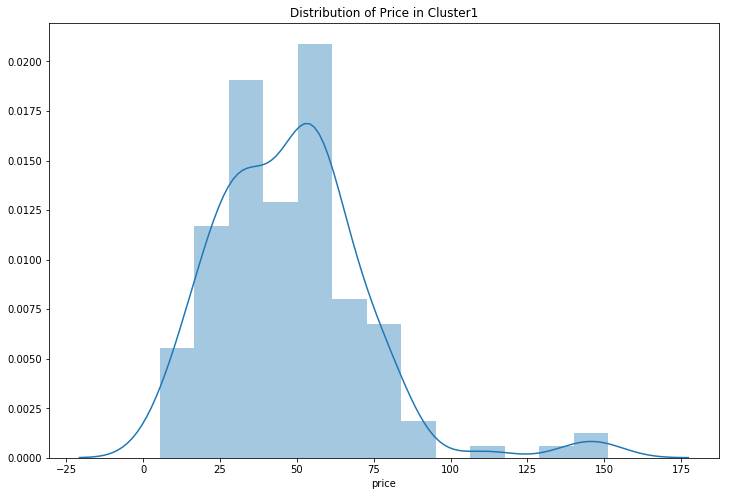

In [38]:
### Plotagem da distribuição dos preços
plt.figure(figsize=(12,8))
plt.title('Distribution of Price in Cluster1')
sns.distplot(cluster1['price'], hist=True,kde=True)

Text(0.5, 1.0, 'Cores mais frequentes Cluster 1')

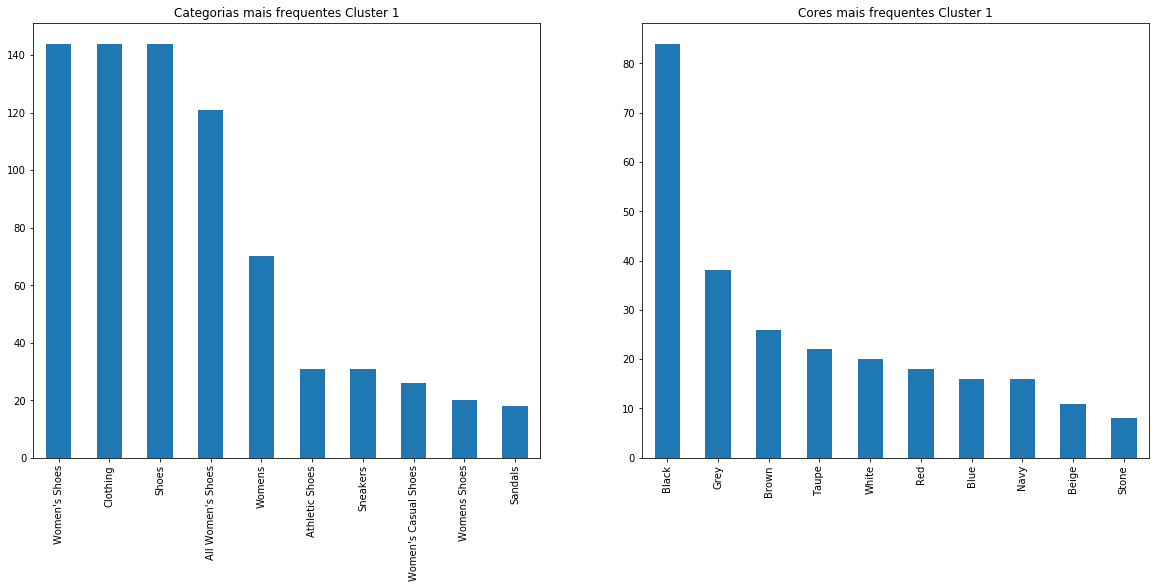

In [39]:
## Visualização das categorias e cores mais frequentes no dataset
top10_colors = cluster1[colors_list].sum().sort_values(ascending=False)[0:10]
top10_categories= cluster1[categories_list].sum().sort_values(ascending=False)[0:10]


fig = plt.figure()
ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

top10_categories.plot(kind='bar', ax=ax0,figsize=(20,8))
ax0.set_title('Categorias mais frequentes Cluster 1')
top10_colors.plot(kind='bar', ax=ax1, figsize=(20,8))
ax1.set_title('Cores mais frequentes Cluster 1')

**Analise Cluster 1:**
 * Maior parte dos produtos tem valores entre R\\$ 25 a R\\$75, com média de R\\$ 47,87 e desvio padrão de R\\$24,50.
 * 73 produtos são novos e 72 usados.
 * As categorias dominantes são Women's Shoes, Clothing e variações de Women's Shoes.
 * Mais da metade dos produtos presentes no dataset são da cor preta.

### Cluster 2

In [40]:
cluster2 = df_sapatos[df_sapatos['Cluster Labels']== 1]
cluster2.head(10)

,Cluster Labels,condition,price,std,2 Lips Too,A2 by Aerosoles,ASICS,All Men's Shoes,All Women's Shoes,All Womens Shoes,Andrew Geller,Apt. 9,Athletic,Athletic Shoes,Baby & Kids Shoes,Baby & Toddler Shoes,Barrow,Betula by Birkenstock,Boat Shoes,Boots,Boys' Shoes,Candie's,Clarks,Clogs,Clothing,Comfort,Corkys,Cowboy Boots,Croft,Dolce by Mojo Moxy,Dr. Scholl's,Eastland,Easy Street,FILA,Fergalicious,Fitness,Flats,Forever Collectibles,Girls' Boots,Girls' Shoes,Heels,Henry Ferrera,Herstar,Home Improvement,Jennifer Lopez,Journee Collection,K-Swiss,Keds,Kisses by 2 Lips Too,Koolaburra by UGG,LC Lauren Conrad,Laredo,LifeStride,Loafers,Low Slide Sandals,Lugz,MUK LUKS,Men's Athletic Shoes,Men's Casual Shoes,Men's Shoes,Mid-Calf Boots,Mules,NYLA,NaturalSoul by naturalizer,New Balance,Nike,Olivia Miller,Other Slip-Ons,Oxfords,PUMA,Pumps,Qupid,REEF,Rampage,Rocky 4EurSole,Running & Yoga,Ryka,SONOMA Goods for Life,Sandals,Sandals & Flip Flops,Seven7,Shoes,Shoes & Accessories,Shop by Clothing Type,Simply Vera Vera Wang,Skechers,Slip-ons,Slippers,Sneakers,Soft Style by Hush Puppies,Sporting Goods,Spring Step,Style Charles by Charles David,Under Armour,Unionbay,Vans,Women,Women's Athletic Shoes,Women's Boots,Women's Casual Boots & Shoes,Women's Casual Shoes,Women's Clothing,Women's Dress Shoes,Women's Footwear,Women's New Balance Shoes,Women's Red Wing Shoes,Women's Road Running Shoes,Women's Running Shoes,Women's Sandals,Women's Shoes,Women's Slippers,Women's Trail Running Shoes,Women's Wear to Work,Women's Winter Boots,Women's Work & Safety Shoes,Womens,Womens Casual Shoes,Womens Comfort,Womens Comfort Boots & Booties,Womens Oxford & Loafers,Womens Oxfords,Womens Sandals & Flip Flops,Womens Shoes,Womens Sport Sandals,Work Safety Clothing and Equipment,...,Hawaiian,Highrisewhite,Honey,Hot,Ice,Indigo,Inkdeadly,Insignia,Ivory,Jiffy,Khaki,Kiwi,Koa,Leopard,Liberty,Licorice,Light,Lilac,Luggage,Lux,Luxe,Madder,Mahogany,Marine,Marlin,Maroon,Mauve,Me,Medieval,Medium,Metallic,Mica,Mint,Moccasin,Mocha,Mojolica,Morning,Multi-Color,Mushroom,Mustang,N,Nasturtium,Natural,Naturalgold,Navy,Navy-Plum-Ice,Navy-Teal-Mint,Navyblue,Neon,Neutral,Nobile,Noble,Nude,Olive,Orange,Orchid,Oro,Oyster,Peach,Pearl,Pewter,Pewterchampagne,Pigeon,Pink,Pinot,Platinum,Poseidon,Premier,Primer,Punch,Pure,Purple,Purple-Pink-Teal,Purpleblack,Quarry,Rainbow,Raspberry,Raspberrywhite,Raw,Red,Redpink,Redyellow,Reflecting,Regatta,Rose,Sage,Sand,Sangria,Silver,Slate,Slateblue,Soft,Steel,Stingraywhite,Stone,Summit,Super,Sweet,Tan,Tanwhite,Taupe,Teal,Team,Tibet,Tibetan,Tideline,Tobacco,Tornado,True,Turbulence,Turquo,Turquoise,Twilight,Utility,Vintage,Virtual,Wheat,White,Whitebrooke,Whitefire,Whitegrey,Whitewhite,Wine,Wood,Yellow
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV_HAsJHHh53nbDR_7AF,1,0,121.875000,11.490485,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AV_KzLOMuC1rwyj_hPU9,1,0,84.247500,6.721050,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [41]:
media = cluster2['price'].mean()
desvio = cluster2['price'].std()
print("Média do cluster 2: {0:.2f}".format(media))
print('Desvio padrão do cluster 2: {0:.2f}'.format(desvio))

Média do cluster 2: 57.36
Desvio padrão do cluster 2: 10.56


In [42]:
## quantidade de sapatos usados no cluster 0, e quantidade de novos 1
cluster2['condition'].value_counts()

0    84
Name: condition, dtype: int64

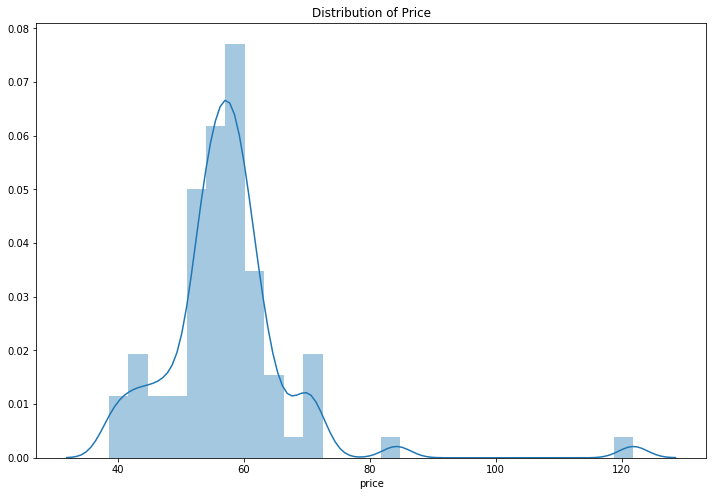

In [43]:
plt.figure(figsize=(12,8))
plt.title('Distribution of Price')
sns.distplot(cluster2['price'])

Text(0.5, 1.0, 'Cores mais frequentes Cluster 2')

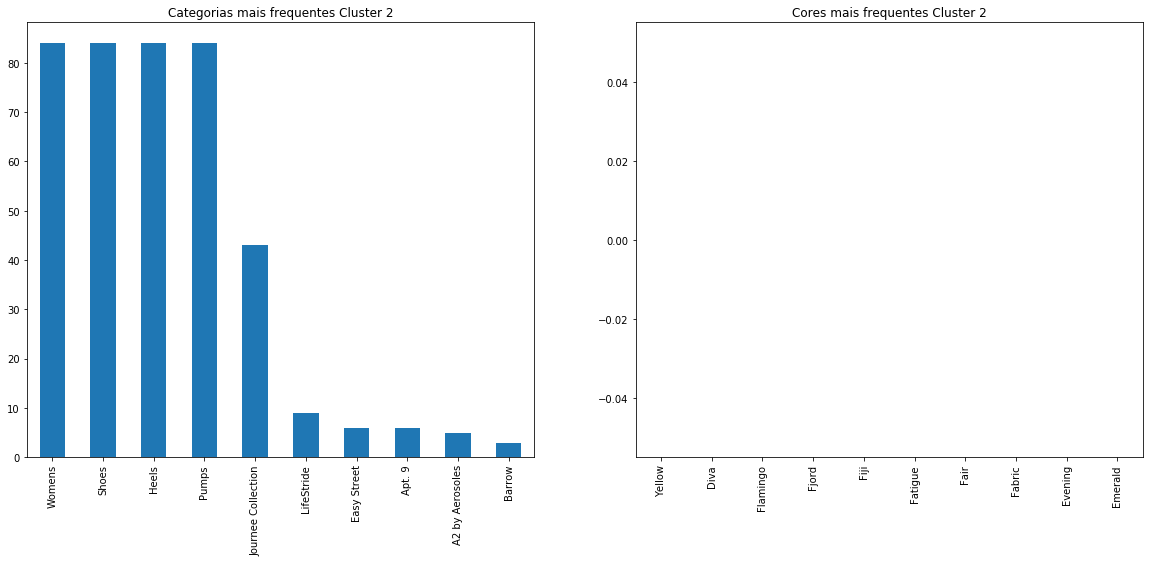

In [44]:
top10_colors = cluster2[colors_list].sum().sort_values(ascending=False)[0:10]
top10_categories= cluster2[categories_list].sum().sort_values(ascending=False)[0:10]


fig = plt.figure()
ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

top10_categories.plot(kind='bar', ax=ax0,figsize=(20,8))
ax0.set_title('Categorias mais frequentes Cluster 2')
top10_colors.plot(kind='bar', ax=ax1, figsize=(20,8))
ax1.set_title('Cores mais frequentes Cluster 2')

**Analise Cluster 2:**
 * Maior parte dos produtos tem valores entre R\\$ 50,00 a R\\$70,00 com média de R\\$ 57,36 e desvio padrão de R\\$10,56.
 * **Todos** os produtos são usados.
 * **Todos** os produtos desse dataset são da classe *Heels* e *Pumps*.
 * Nenhum produto do daset apresenta descrição de cor.

### Cluster 3

In [45]:
cluster3 = df_sapatos[df_sapatos['Cluster Labels']== 2]
cluster3.head(10)

,Cluster Labels,condition,price,std,2 Lips Too,A2 by Aerosoles,ASICS,All Men's Shoes,All Women's Shoes,All Womens Shoes,Andrew Geller,Apt. 9,Athletic,Athletic Shoes,Baby & Kids Shoes,Baby & Toddler Shoes,Barrow,Betula by Birkenstock,Boat Shoes,Boots,Boys' Shoes,Candie's,Clarks,Clogs,Clothing,Comfort,Corkys,Cowboy Boots,Croft,Dolce by Mojo Moxy,Dr. Scholl's,Eastland,Easy Street,FILA,Fergalicious,Fitness,Flats,Forever Collectibles,Girls' Boots,Girls' Shoes,Heels,Henry Ferrera,Herstar,Home Improvement,Jennifer Lopez,Journee Collection,K-Swiss,Keds,Kisses by 2 Lips Too,Koolaburra by UGG,LC Lauren Conrad,Laredo,LifeStride,Loafers,Low Slide Sandals,Lugz,MUK LUKS,Men's Athletic Shoes,Men's Casual Shoes,Men's Shoes,Mid-Calf Boots,Mules,NYLA,NaturalSoul by naturalizer,New Balance,Nike,Olivia Miller,Other Slip-Ons,Oxfords,PUMA,Pumps,Qupid,REEF,Rampage,Rocky 4EurSole,Running & Yoga,Ryka,SONOMA Goods for Life,Sandals,Sandals & Flip Flops,Seven7,Shoes,Shoes & Accessories,Shop by Clothing Type,Simply Vera Vera Wang,Skechers,Slip-ons,Slippers,Sneakers,Soft Style by Hush Puppies,Sporting Goods,Spring Step,Style Charles by Charles David,Under Armour,Unionbay,Vans,Women,Women's Athletic Shoes,Women's Boots,Women's Casual Boots & Shoes,Women's Casual Shoes,Women's Clothing,Women's Dress Shoes,Women's Footwear,Women's New Balance Shoes,Women's Red Wing Shoes,Women's Road Running Shoes,Women's Running Shoes,Women's Sandals,Women's Shoes,Women's Slippers,Women's Trail Running Shoes,Women's Wear to Work,Women's Winter Boots,Women's Work & Safety Shoes,Womens,Womens Casual Shoes,Womens Comfort,Womens Comfort Boots & Booties,Womens Oxford & Loafers,Womens Oxfords,Womens Sandals & Flip Flops,Womens Shoes,Womens Sport Sandals,Work Safety Clothing and Equipment,...,Hawaiian,Highrisewhite,Honey,Hot,Ice,Indigo,Inkdeadly,Insignia,Ivory,Jiffy,Khaki,Kiwi,Koa,Leopard,Liberty,Licorice,Light,Lilac,Luggage,Lux,Luxe,Madder,Mahogany,Marine,Marlin,Maroon,Mauve,Me,Medieval,Medium,Metallic,Mica,Mint,Moccasin,Mocha,Mojolica,Morning,Multi-Color,Mushroom,Mustang,N,Nasturtium,Natural,Naturalgold,Navy,Navy-Plum-Ice,Navy-Teal-Mint,Navyblue,Neon,Neutral,Nobile,Noble,Nude,Olive,Orange,Orchid,Oro,Oyster,Peach,Pearl,Pewter,Pewterchampagne,Pigeon,Pink,Pinot,Platinum,Poseidon,Premier,Primer,Punch,Pure,Purple,Purple-Pink-Teal,Purpleblack,Quarry,Rainbow,Raspberry,Raspberrywhite,Raw,Red,Redpink,Redyellow,Reflecting,Regatta,Rose,Sage,Sand,Sangria,Silver,Slate,Slateblue,Soft,Steel,Stingraywhite,Stone,Summit,Super,Sweet,Tan,Tanwhite,Taupe,Teal,Team,Tibet,Tibetan,Tideline,Tobacco,Tornado,True,Turbulence,Turquo,Turquoise,Twilight,Utility,Vintage,Virtual,Wheat,White,Whitebrooke,Whitefire,Whitegrey,Whitewhite,Wine,Wood,Yellow
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AWKb402vYSSHbkXwyyw5,2,1,115.500000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AWKb6yR4Hh53nbDRIhMA,2,1,150.166667,17.176171,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [46]:
media = cluster3['price'].mean()
desvio = cluster3['price'].std()
print("Média do cluster 3: {0:.2f}".format(media))
print('Desvio padrão do cluster 3: {0:.2f}'.format(desvio))

Média do cluster 3: 112.56
Desvio padrão do cluster 3: 36.56


In [47]:
## quantidade de sapatos usados no dataset 0, e quantidade de novos 1
cluster3['condition'].value_counts()

1    119
Name: condition, dtype: int64

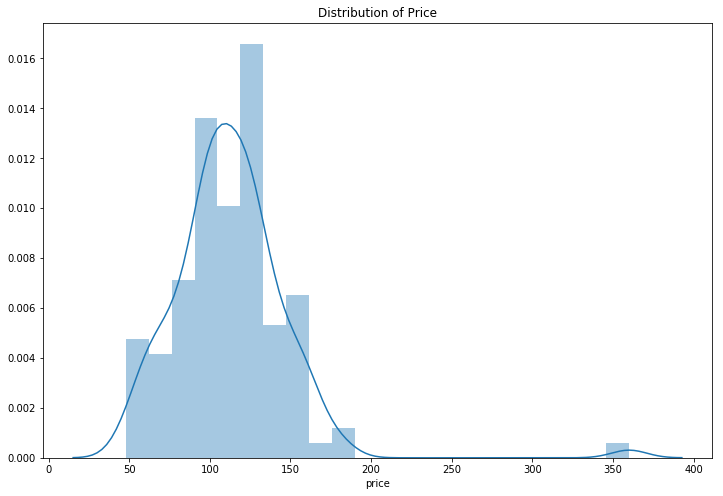

In [48]:
plt.figure(figsize=(12,8))
plt.title('Distribution of Price')
sns.distplot(cluster3['price'])

Text(0.5, 1.0, 'Cores mais frequentes Cluster 3')

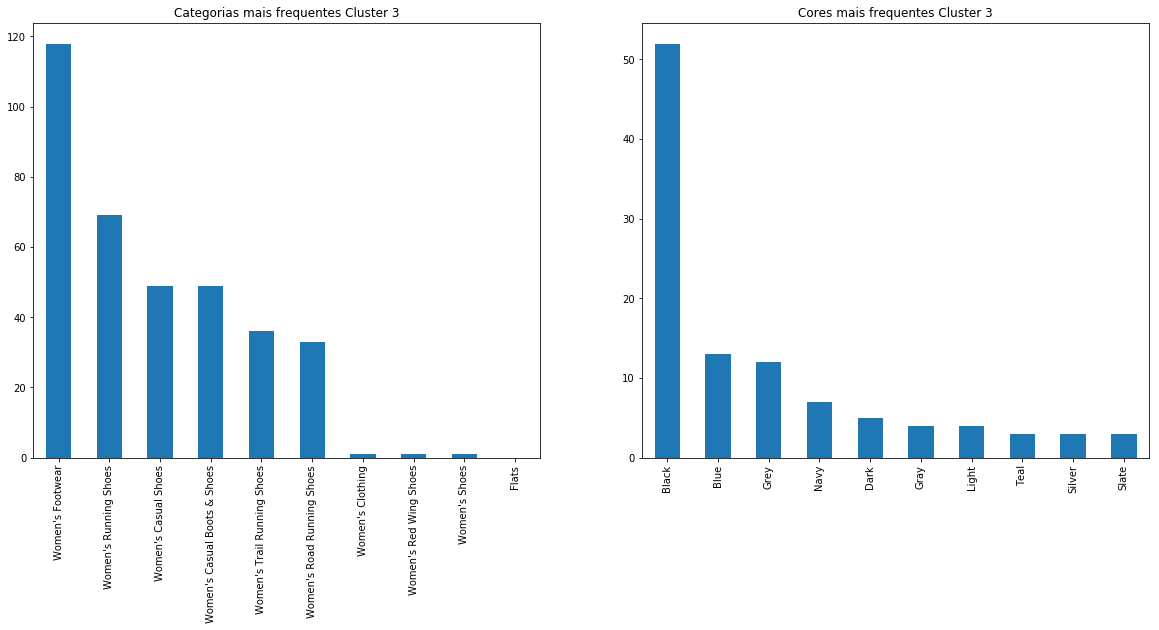

In [49]:
top10_colors = cluster3[colors_list].sum().sort_values(ascending=False)[0:10]
top10_categories= cluster3[categories_list].sum().sort_values(ascending=False)[0:10]


fig = plt.figure()
ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

top10_categories.plot(kind='bar', ax=ax0,figsize=(20,8))
ax0.set_title('Categorias mais frequentes Cluster 3')
top10_colors.plot(kind='bar', ax=ax1, figsize=(20,8))
ax1.set_title('Cores mais frequentes Cluster 3')

**Analise Cluster 3:**
 * Cluster que apresenta a maior média de preços com média de R\\$ 112,56 e desvio padrão de R\\$36,56.
 * **Todos** os produtos são Novos.
 * **Todos** os produtos desse dataset são da classe *Women's Footwear*.
 * Cor preta predominante no dataset 

### Cluster 4

In [50]:
cluster4 = df_sapatos[df_sapatos['Cluster Labels']== 3]
cluster4.head(10)

,Cluster Labels,condition,price,std,2 Lips Too,A2 by Aerosoles,ASICS,All Men's Shoes,All Women's Shoes,All Womens Shoes,Andrew Geller,Apt. 9,Athletic,Athletic Shoes,Baby & Kids Shoes,Baby & Toddler Shoes,Barrow,Betula by Birkenstock,Boat Shoes,Boots,Boys' Shoes,Candie's,Clarks,Clogs,Clothing,Comfort,Corkys,Cowboy Boots,Croft,Dolce by Mojo Moxy,Dr. Scholl's,Eastland,Easy Street,FILA,Fergalicious,Fitness,Flats,Forever Collectibles,Girls' Boots,Girls' Shoes,Heels,Henry Ferrera,Herstar,Home Improvement,Jennifer Lopez,Journee Collection,K-Swiss,Keds,Kisses by 2 Lips Too,Koolaburra by UGG,LC Lauren Conrad,Laredo,LifeStride,Loafers,Low Slide Sandals,Lugz,MUK LUKS,Men's Athletic Shoes,Men's Casual Shoes,Men's Shoes,Mid-Calf Boots,Mules,NYLA,NaturalSoul by naturalizer,New Balance,Nike,Olivia Miller,Other Slip-Ons,Oxfords,PUMA,Pumps,Qupid,REEF,Rampage,Rocky 4EurSole,Running & Yoga,Ryka,SONOMA Goods for Life,Sandals,Sandals & Flip Flops,Seven7,Shoes,Shoes & Accessories,Shop by Clothing Type,Simply Vera Vera Wang,Skechers,Slip-ons,Slippers,Sneakers,Soft Style by Hush Puppies,Sporting Goods,Spring Step,Style Charles by Charles David,Under Armour,Unionbay,Vans,Women,Women's Athletic Shoes,Women's Boots,Women's Casual Boots & Shoes,Women's Casual Shoes,Women's Clothing,Women's Dress Shoes,Women's Footwear,Women's New Balance Shoes,Women's Red Wing Shoes,Women's Road Running Shoes,Women's Running Shoes,Women's Sandals,Women's Shoes,Women's Slippers,Women's Trail Running Shoes,Women's Wear to Work,Women's Winter Boots,Women's Work & Safety Shoes,Womens,Womens Casual Shoes,Womens Comfort,Womens Comfort Boots & Booties,Womens Oxford & Loafers,Womens Oxfords,Womens Sandals & Flip Flops,Womens Shoes,Womens Sport Sandals,Work Safety Clothing and Equipment,...,Hawaiian,Highrisewhite,Honey,Hot,Ice,Indigo,Inkdeadly,Insignia,Ivory,Jiffy,Khaki,Kiwi,Koa,Leopard,Liberty,Licorice,Light,Lilac,Luggage,Lux,Luxe,Madder,Mahogany,Marine,Marlin,Maroon,Mauve,Me,Medieval,Medium,Metallic,Mica,Mint,Moccasin,Mocha,Mojolica,Morning,Multi-Color,Mushroom,Mustang,N,Nasturtium,Natural,Naturalgold,Navy,Navy-Plum-Ice,Navy-Teal-Mint,Navyblue,Neon,Neutral,Nobile,Noble,Nude,Olive,Orange,Orchid,Oro,Oyster,Peach,Pearl,Pewter,Pewterchampagne,Pigeon,Pink,Pinot,Platinum,Poseidon,Premier,Primer,Punch,Pure,Purple,Purple-Pink-Teal,Purpleblack,Quarry,Rainbow,Raspberry,Raspberrywhite,Raw,Red,Redpink,Redyellow,Reflecting,Regatta,Rose,Sage,Sand,Sangria,Silver,Slate,Slateblue,Soft,Steel,Stingraywhite,Stone,Summit,Super,Sweet,Tan,Tanwhite,Taupe,Teal,Team,Tibet,Tibetan,Tideline,Tobacco,Tornado,True,Turbulence,Turquo,Turquoise,Twilight,Utility,Vintage,Virtual,Wheat,White,Whitebrooke,Whitefire,Whitegrey,Whitewhite,Wine,Wood,Yellow
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AWDXWRLjuC1rwyj_lXHA,3,0,49.990,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AWDG2vWPYSSHbkXwuNeF,3,0,57.490,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [51]:
media = cluster4['price'].mean()
desvio = cluster4['price'].std()
print("Média do cluster 4: {0:.2f}".format(media))
print('Desvio padrão do cluster 4: {0:.2f}'.format(desvio))

Média do cluster 4: 61.06
Desvio padrão do cluster 4: 21.36


In [52]:
## quantidade de sapatos usados no dataset 0, e quantidade de novos 1
cluster4['condition'].value_counts()

0    305
Name: condition, dtype: int64

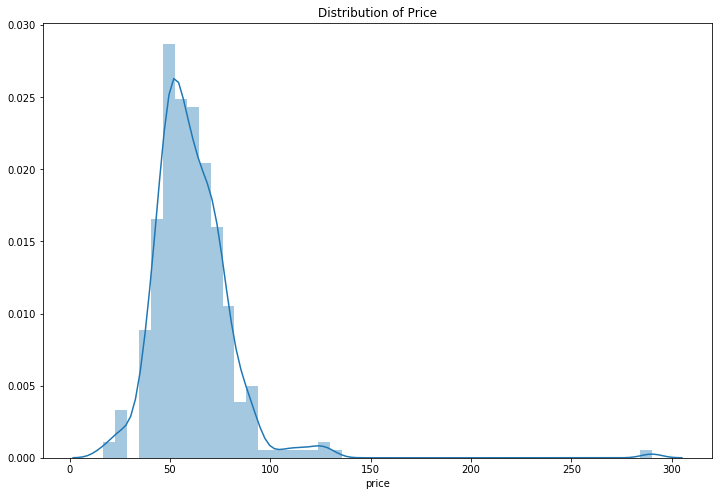

In [53]:
plt.figure(figsize=(12,8))
plt.title('Distribution of Price')
sns.distplot(cluster4['price'])

[]

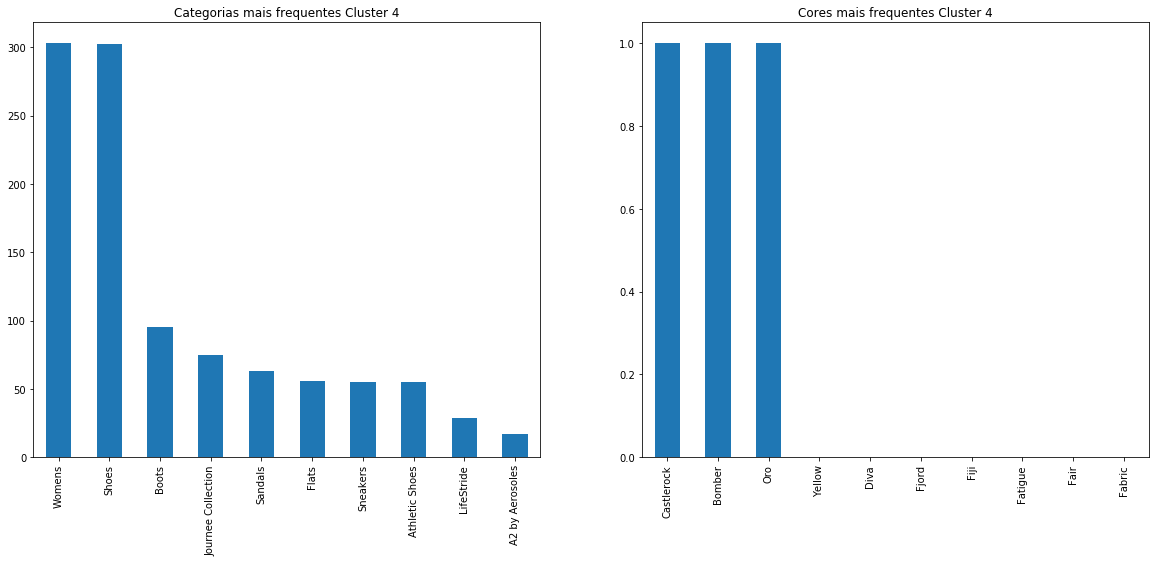

In [54]:
top10_colors = cluster4[colors_list].sum().sort_values(ascending=False)[0:10]
top10_categories= cluster4[categories_list].sum().sort_values(ascending=False)[0:10]


fig = plt.figure()
ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

top10_categories.plot(kind='bar', ax=ax0,figsize=(20,8))
ax0.set_title('Categorias mais frequentes Cluster 4')
top10_colors.plot(kind='bar', ax=ax1, figsize=(20,8))
ax1.set_title('Cores mais frequentes Cluster 4')

plt.plot()

**Analise Cluster 4:**
 * Cluster com maior quantidade de produtos.
 * Cluster com média de R\\$ 61,06 e desvio padrão de R\\$21,36.
 * Média do cluster similar com a média do dataset original, porem com desvio padrão menor.
 * **Todos** os produtos são usados.
 * **Todos** os produtos desse dataset são da classe *Womens* e *Shoes*.
 * Com exceção de 3 produtos, nenhum outro produto possue descrição de cor. 

### Salvando ids dos produtos com seus respectivos Clusters Labels

In [70]:
Clusters = df_sapatos[['Cluster Labels']]
Clusters.reset_index(level=0,inplace=True)

In [71]:
with open('cluster_ids.json', 'w', encoding='utf-8') as file:
    Clusters.to_json(file, force_ascii=False, orient='records', lines=True)